In [1]:
import sys
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt

sys.path.append('/home/haleysanders/haley_ws/src/rad_models/src/rad_models/')
from MassSpringDamper import MassSpringDamper
from tqdm import tqdm


# **Dataset**

In [2]:
class DynamicSystemDataSet():
    
    def __init__(self, system):
        
        # dynamic model of system we care about (ie mass spring damper, inverted pendulum, etc.)
        self.system = system
        self.system.uMin = -self.system.uMax
        
        # timestep
        self.dt = .01
        
    def forward_simulate(self, state, input, steps, visualize=False):
        
        # convert state and inputs from torch tensors to numpy arrays
        state = self.convert_to_numpy_array(state, self.system.numStates)
        input = self.convert_to_numpy_array(input, self.system.numInputs)
        
        for i in range(steps):    
            # get next state by forward simulating
            state = self.system.forward_simulate_dt(state, input, self.dt)
            
            # visualize
            if visualize == True:
                if i%10==0:
                    self.system.visualize(state, input)
        
        # convert next state back to torch tensor
        nextState = self.convert_to_torch_tensor(state)
        
        return nextState.cuda(non_blocking=True)
    
    def convert_to_numpy_array(self, tensor, arrayDim):
        
        convertedArray = np.zeros([arrayDim, 1])
        convertedArray[:, 0] = np.array(tensor)    
        
        return np.array(convertedArray)
    
    def convert_to_torch_tensor(self, array):
        
        array = array.flatten()        
        tensor = torch.Tensor(array)
        
        return tensor

# **Experiment 1**

In [3]:
class LinearNetwork(nn.Module):
  def __init__(self, numVars):
    super(LinearNetwork, self).__init__()

    self.net = nn.Sequential(nn.Linear(numVars, 100), 
                             nn.ReLU(),
                             nn.Linear(100, numVars - 1))
  
  def forward(self, x):
    return self.net(x)
  

def calculate_loss(yHat, yTruth):
    
    error = yHat - yTruth
    costWeights = torch.Tensor([[1, 0], [0, 1]]).cuda()
    
    loss = 0
    for h in range(error.shape[0]):
        loss = loss + torch.matmul(torch.matmul(error[h, :], costWeights), torch.unsqueeze(error[h, :], 1))
    
    return loss

In [4]:
#"Dataset" Variables
system = MassSpringDamper()
dataset = DynamicSystemDataSet(system)

# Model and loss and optimizer functions
numVars = dataset.system.numStates + dataset.system.numInputs
model = LinearNetwork(numVars).cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
objective = torch.nn.CrossEntropyLoss()

In [5]:
# Instatiate training and validation losses
train_losses = []
validation_losses = []
batch_size = 100

num_epochs = 1000000
loop = tqdm(total=num_epochs, position=0)

# Training and Validation Loops
for epoch in range(num_epochs):

    # zero out gradients
    optimizer.zero_grad()
    
    # generate random state and input
    state = (10--10)*torch.rand((batch_size, 2)) - 10
    input = (10--10)*torch.rand((batch_size, 1)) - 10
    
    # get true next state value
    nextStateTruth = torch.zeros((batch_size, 2)).cuda(non_blocking=True)
    for j in range(state.shape[0]):
        nextStateTruth[j, :] = dataset.forward_simulate(state[j, :], input[j], steps = 1)
        
    # get next state value from network
    stateAndInput = torch.hstack((state, input)).cuda(non_blocking=True)
    nextStateHat = model.forward(stateAndInput)
        
    # calculate loss
    loss = calculate_loss(nextStateHat, nextStateTruth)
    
    if epoch % 100 == 0:
        
        # save training losses
        train_losses.append(loss.item())
        
        # generate random validation state and input
        stateValidate = (10--10)*torch.rand((batch_size, 2)) - 10
        inputValidate = (10--10)*torch.rand((batch_size, 1)) - 10
        
        # get true next state value
        nextStateTruthValidate = torch.zeros((batch_size, 2)).cuda(non_blocking=True)
        for j in range(stateValidate.shape[0]):
            nextStateTruthValidate[j, :] = dataset.forward_simulate(stateValidate[j, :], inputValidate[j], steps = 1)
            
        # get next state value from network
        stateAndInputValidate = torch.hstack((stateValidate, inputValidate)).cuda(non_blocking=True)
        nextStateHatValidate = model.forward(stateAndInputValidate)
        
        # save validation losses
        lossValidate = calculate_loss(nextStateHatValidate, nextStateTruthValidate)
        validation_losses.append(lossValidate.item())
    
    loop.set_description('epoch:{} loss:{:.4f} val_loss:{:4f}'.format(epoch, loss.item(), validation_losses[-1]))  
    loop.update(True)      
    
    loss.backward()
    optimizer.step()
    
loop.close()


epoch:999 loss:8.4736 val_loss:18.725128: 100%|██████████| 1000/1000 [00:20<00:00, 48.64it/s]    


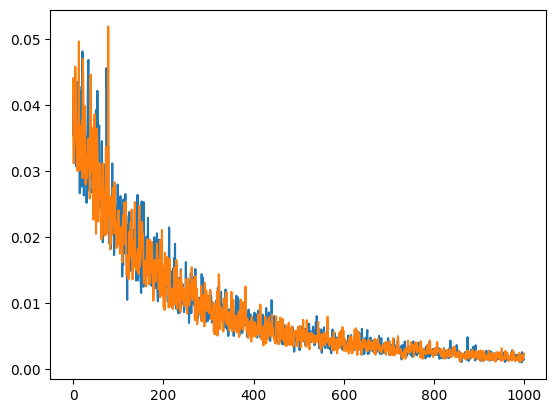

In [ ]:
fig = plt.figure()
plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
plt.plot(range(len(validation_losses)), validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.show()

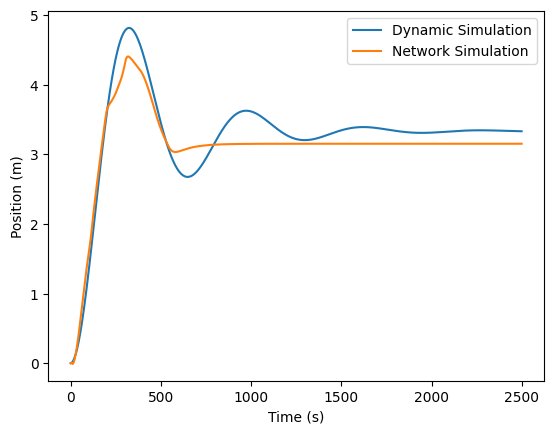

In [ ]:
stateTruth = np.array([[0.0], [0.0]])
input = 10.0
stateAndInput = torch.Tensor([0.0, 0.0, input]).cuda()

steps = 2500
stateTruthHist = np.zeros((2, steps))
stateHatHist = torch.zeros((2, steps))

for i in range(steps):
    
    stateTruth = dataset.system.forward_simulate_dt(stateTruth, input, dataset.dt)
    stateTruthHist[:, i] = stateTruth.flatten()

    stateHat = model.forward(stateAndInput)
    stateAndInput = torch.Tensor([stateHat[0], stateHat[1], input]).cuda()
    stateHatHist[:, i] = stateHat.flatten()

plt.plot(stateTruthHist[0, :])
plt.plot(stateHatHist.detach().numpy()[0, :])
plt.legend(['Dynamic Simulation', 'Network Simulation'])
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.show()

In [ ]:
# Get number of parameters in network
sum = 0
for p in model.parameters():
  params  = 1
  for s in p.size():
    params = params * s
  sum = sum + params
print('Number of Parameters In Network: ', sum)

Number of Parameters In Network:  602
